In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter

In [3]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib
from src.baseline_models import QuantileRegressionNetwork

In [4]:
config_dir = 'config_files/'
config_file = 'config0.json'
with open(config_dir + config_file, 'r') as f: config = json.load(f)

In [5]:
config["data"]["subsample_rate"]["user"] = 1
config["data"]["condition_tag_list"] = ["months", "weekdays", "day_befores"]    ## day_befores is always at the end
config["data"]["ampute_params"]["b"] = 1000
config["data"]["dirichlet_transform_style"] = "mean"

In [6]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=1000
Mean of enrolments: 0.31
Number of Training Points...............1493743
Number of Testing Points................498590
Number of Validation Points.............498455
Number of Missing Points.................2162


In [7]:
targets_train = trainset.inputs
targets_val = valset.inputs
inputs, contexts = {}, {}

for set_type in ["train", "val", "test"]:
    inputs[set_type] = condition_set[set_type]["day_befores"]
    contexts[set_type] = conditioner.transform(condition_set[set_type])[:,:-24]

In [8]:
class ContexedDataset(torch.utils.data.Dataset):
    def __init__(self, targets, inputs, context):
        self.targets = torch.tensor(targets).float()
        self.inputs = torch.tensor(inputs).float()
        self.context = torch.tensor(context).float()

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return  self.inputs[idx], self.context[idx], self.targets[idx]

In [9]:
trainset = ContexedDataset(targets_train, inputs["train"], contexts["train"])
valset = ContexedDataset(targets_val, inputs["val"], contexts["val"])

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=1024, shuffle=False)

# Hyperparameters for model
hidden_sizes = [1500]*5
quantiles = [.05, .10, .25, .40, .50, .60, .75, .90, .95]  # List of quantiles to predict
quantile_weights = np.ones(len(quantiles))  # Weigh the quantiles linearly in the loss

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = QuantileRegressionNetwork(input_size=trainset[0][0].shape[0], 
                                  context_size=trainset[0][1].shape[0], 
                                  output_size=trainset[0][2].shape[0], 
                                  hidden_sizes=hidden_sizes, 
                                  quantiles=quantiles,
                                  quantile_weights=quantile_weights,
                                  device=device)

In [12]:
#number of paremeters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 9373716


In [ ]:
model.train_model(train_loader=train_loader, 
                  val_loader=val_loader, 
                  num_epochs = 1000, 
                  learning_rate = 1e-3, 
                  validation_freq = 500, 
                  patience = 5,
                  verbose_freq = 100)

Epoch 1/1000, Training Loss: 0.2554
Epoch 1/1000, Training Loss: 0.2228
Epoch 1/1000, Training Loss: 0.2081
Epoch 1/1000, Training Loss: 0.1983
Epoch 1/1000, Training Loss: 0.1924
Epoch 1/1000, Validation Loss: 0.1641
Epoch 1/1000, Training Loss: 0.1881
Epoch 1/1000, Training Loss: 0.1849
Epoch 1/1000, Training Loss: 0.1826
Epoch 1/1000, Training Loss: 0.1806
Epoch 1/1000, Training Loss: 0.1791
Epoch 1/1000, Validation Loss: 0.1630
Epoch 1/1000, Training Loss: 0.1778
Epoch 1/1000, Training Loss: 0.1767
Epoch 1/1000, Training Loss: 0.1758
Epoch 1/1000, Training Loss: 0.1750
Epoch 2/1000, Training Loss: 0.1645
Epoch 2/1000, Training Loss: 0.1640
Epoch 2/1000, Training Loss: 0.1641
Epoch 2/1000, Training Loss: 0.1641
Epoch 2/1000, Training Loss: 0.1640
Epoch 2/1000, Validation Loss: 0.1615
Epoch 2/1000, Training Loss: 0.1642
Epoch 2/1000, Training Loss: 0.1642
Epoch 2/1000, Training Loss: 0.1643
Epoch 2/1000, Training Loss: 0.1643
Epoch 2/1000, Training Loss: 0.1643
Epoch 2/1000, Validati

In [30]:
num_users = user_ids["train"][-1]+1

In [137]:
quantiles_test = model(torch.tensor(inputs_test).float().to(device), torch.tensor(context_test).float().to(device)).clamp(min=-3).detach().cpu().numpy().transpose(2, 0, 1)
quantiles_test_denorm = utils.zero_preserved_log_denormalize(quantiles_test, nonzero_mean, nonzero_std, log_input=True)

quantiles_test = quantiles_test.reshape(len(quantiles), num_users, -1)
quantiles_test_denorm = quantiles_test_denorm.reshape(len(quantiles), num_users, -1)

X_test_denorm = utils.zero_preserved_log_denormalize(X_test, nonzero_mean, nonzero_std, log_input=True).reshape(user_ids["train"][-1]+1,-1)

In [138]:
user_idx = 55
start_day = 30
end_day = 50

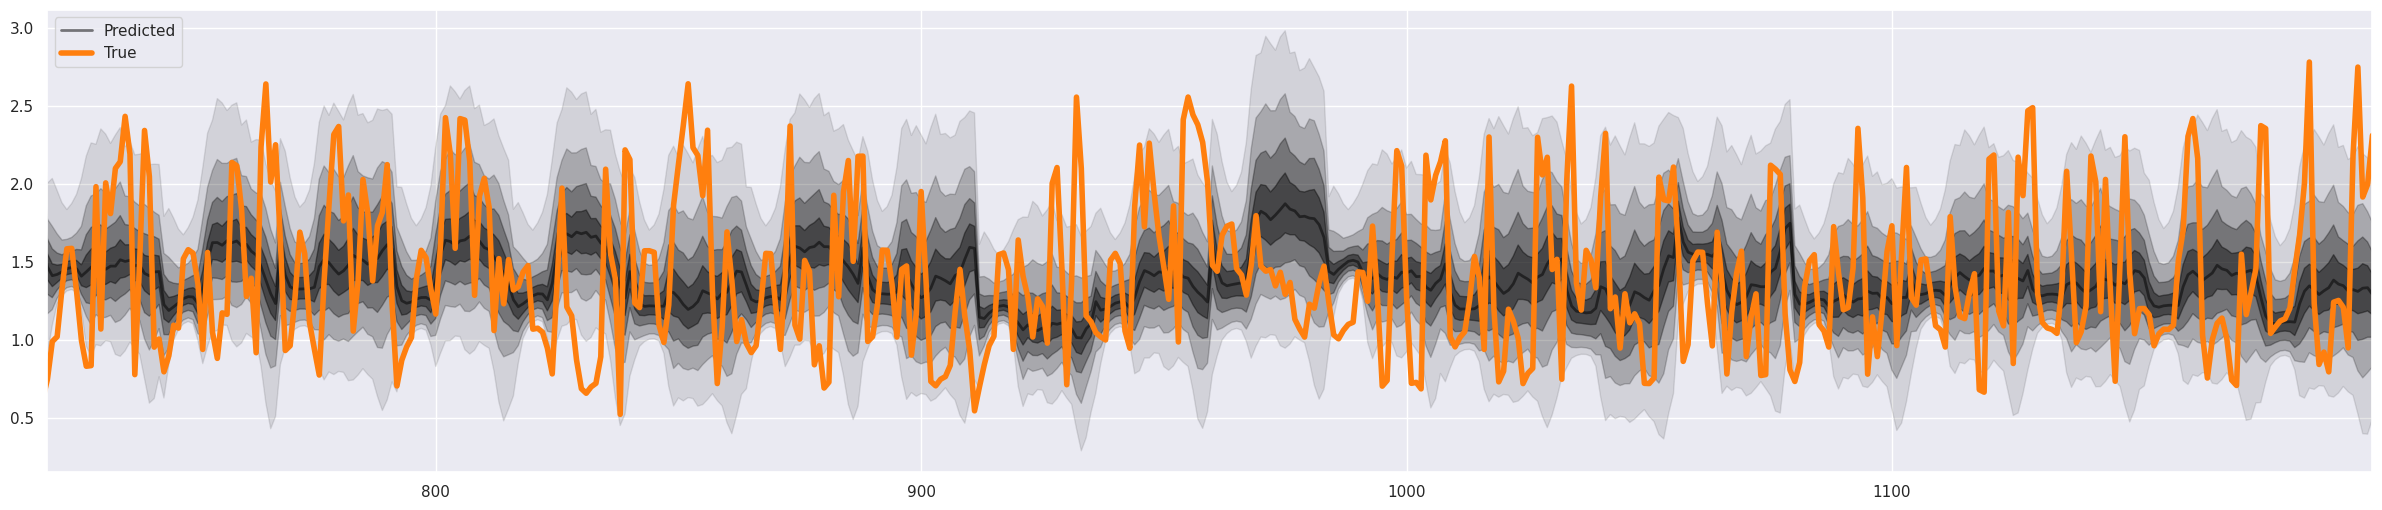

In [139]:
fig, ax = plt.subplots(figsize=(30, 6))
for i in range(quantiles.__len__()//2):
    ax.fill_between(np.arange(quantiles_test.shape[-1]),quantiles_test[i,user_idx,:], quantiles_test[-(i+1),user_idx,:], alpha=1*quantiles[i], color="black")
ax.plot(quantiles_test[quantiles.__len__()//2,user_idx,:], label="Predicted", color="black", lw=2, alpha=0.5)

ax.plot(X_test.reshape(num_users,-1)[user_idx], label="True", lw=4, alpha=1.0, color="tab:orange")
ax.legend()

plt.xlim(24*start_day, 24*end_day-1)
plt.show()


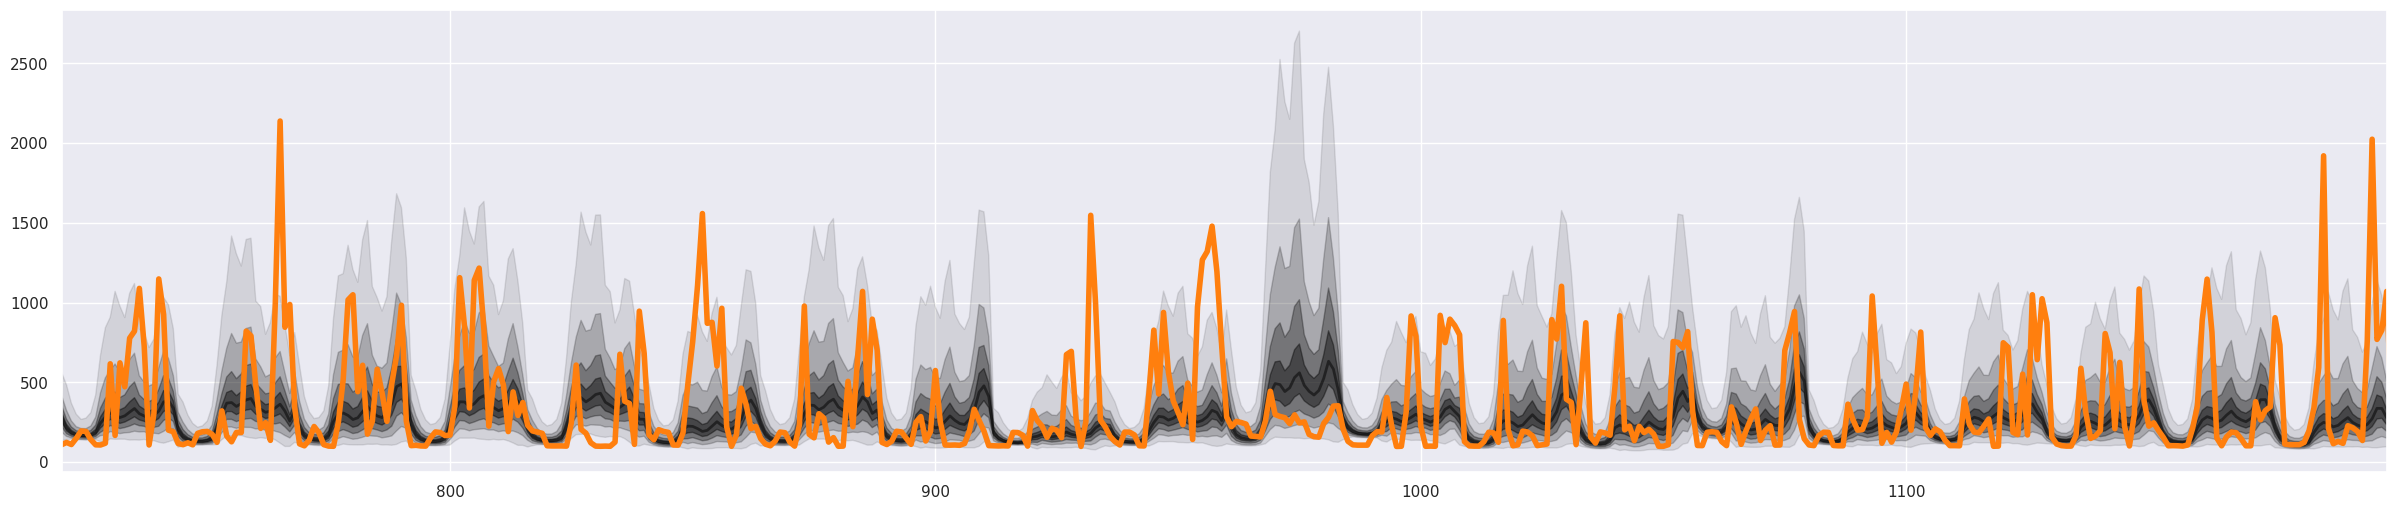

In [140]:
fig, ax = plt.subplots(figsize=(30, 6))
for i in range(quantiles.__len__()//2):
    ax.fill_between(np.arange(quantiles_test_denorm.shape[-1]),quantiles_test_denorm[i,user_idx,:], quantiles_test_denorm[-(i+1),user_idx,:], alpha=1*quantiles[i], color="black")
ax.plot(quantiles_test_denorm[quantiles.__len__()//2,user_idx,:], label="Predicted", color="black", lw=2, alpha=0.5)

ax.plot(X_test_denorm[user_idx], label="True", lw=4, alpha=1.0, color="tab:orange")
# ax.set_yscale("log")

plt.xlim(24*start_day, 24*end_day-1)
plt.show()

In [141]:
def calculate_quantile_loss(predictions, targets, quantiles):
    total_loss = 0.0
    
    for i, q in enumerate(quantiles):
        errors = targets - predictions[i]
        loss = np.max(((q - 1) * errors, q * errors), axis=0).mean()
        total_loss += loss
    
    return total_loss / len(quantiles)

In [142]:
calculate_quantile_loss(quantiles_test_denorm, X_test_denorm, quantiles)

71.82092760172036

In [143]:
calculate_quantile_loss(quantiles_test, X_test.reshape(num_users,-1), quantiles)

0.1629083810399812

In [162]:
def calibration_plot_with_coverage(y_true, quantile_predictions, quantiles):
    coverage = []

    for i, q in enumerate(quantiles):
        # Calculate the proportion of observed values below the predicted quantile
        observed_below = np.mean(np.prod(y_true <= quantile_predictions[i],axis=-1))
        coverage.append(observed_below)
    
    # Calculate the coverage score (mean absolute deviation from perfect calibration)
    coverage_score = np.mean(np.abs(np.array(coverage) - np.array(quantiles)))

    return coverage, coverage_score

In [163]:
num_test_days = int(X_test.shape[0]/num_users)

In [164]:
coverage_scores_denorm, coverage_score_denorm = calibration_plot_with_coverage(X_test_denorm.reshape(num_users,num_test_days,-1), quantiles_test_denorm.reshape(len(quantiles), num_users,num_test_days,-1), quantiles)
coverage_scores, coverage_score = calibration_plot_with_coverage(X_test.reshape(num_users,num_test_days,-1), quantiles_test.reshape(len(quantiles), num_users,num_test_days,-1), quantiles)

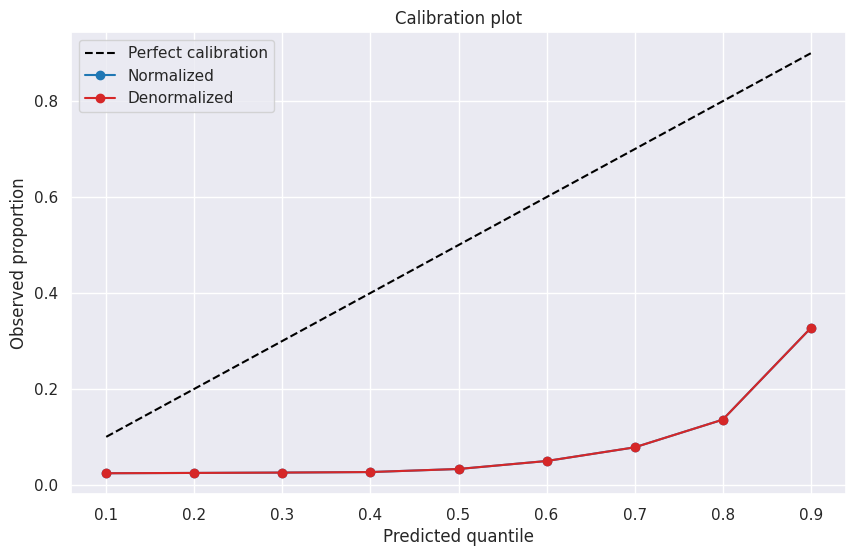

In [165]:
plt.figure(figsize=(10, 6))
plt.plot(quantiles, quantiles, linestyle="--", color="black", label="Perfect calibration")
plt.plot(quantiles, coverage_scores, marker="o", color="tab:blue", label="Normalized")
plt.plot(quantiles, coverage_scores_denorm, marker="o", color="tab:red", label="Denormalized")
plt.xlabel("Predicted quantile")
plt.ylabel("Observed proportion")
plt.title("Calibration plot")
plt.legend()
plt.show()

In [1]:
def interval_score(y_true, lower_bounds, upper_bounds, alpha):
    # Calculate penalties for observations outside the interval
    penalties_lower = np.maximum(0, lower_bounds - y_true)
    penalties_upper = np.maximum(0, y_true - upper_bounds)
    
    # Calculate the interval score
    interval_scores = (upper_bounds - lower_bounds) + (2 / alpha) * penalties_lower + (2 / alpha) * penalties_upper
    
    return interval_scores.mean()

In [2]:
iqr_values = [quantiles[-i-1]-quantiles[i] for i in range(quantiles.__len__()//2)]

NameError: name 'quantiles' is not defined

In [3]:
interval_scores, interval_scores_denorm = [], []
for i in range(len(quantiles)//2):
    interval_scores_denorm.append(interval_score(X_test_denorm, quantiles_test_denorm[i], quantiles_test_denorm[-i-1], alpha=1-iqr_values[i]))
    interval_scores.append(interval_score(X_test.reshape(num_users,-1), quantiles_test[i], quantiles_test[-i-1], alpha=1-iqr_values[i]))

NameError: name 'quantiles' is not defined

In [153]:
interval_scores

[2.0905099285030198, 1.511722490210529, 1.201076656195329, 0.9819568792409972]

In [154]:
interval_scores_denorm

[1040.1168779559177, 682.995055517658, 518.3468277669285, 414.3888532845636]

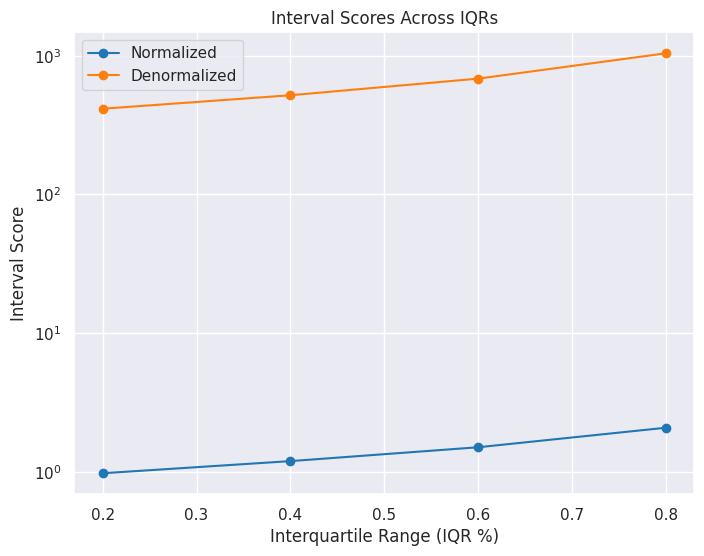

In [155]:
plt.figure(figsize=(8, 6))
plt.plot(iqr_values, interval_scores, marker="o", color="tab:blue", label="Normalized")
plt.plot(iqr_values, interval_scores_denorm, marker="o", color="tab:orange", label="Denormalized")
plt.title("Interval Scores Across IQRs")
plt.xlabel("Interquartile Range (IQR %)")
plt.ylabel("Interval Score")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()


In [156]:
def calculate_interval_coverage_score(y_true, lower_bounds, upper_bounds, iqr):
    within_bounds = (y_true >= lower_bounds) & (y_true <= upper_bounds)
    interval_coverage = np.mean(within_bounds) 
    return interval_coverage

In [157]:
interval_coverage_scores, interval_coverage_scores_denorm = [], []
for i in range(len(quantiles)//2):
    interval_coverage_scores_denorm.append(calculate_interval_coverage_score(X_test_denorm, quantiles_test_denorm[i], quantiles_test_denorm[-i-1], iqr_values[i]))
    interval_coverage_scores.append(calculate_interval_coverage_score(X_test.reshape(num_users,-1), quantiles_test[i], quantiles_test[-i-1], iqr_values[i]))

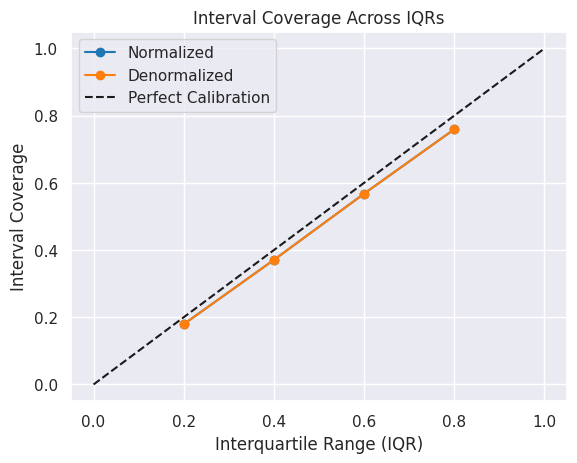

In [158]:
plt.plot(iqr_values, interval_coverage_scores, marker="o", color="tab:blue", label="Normalized")
plt.plot(iqr_values, interval_coverage_scores_denorm, marker="o", color="tab:orange", label="Denormalized")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Interquartile Range (IQR)")
plt.ylabel("Interval Coverage")
plt.title("Interval Coverage Across IQRs")
plt.grid(True)
plt.legend()
plt.show()

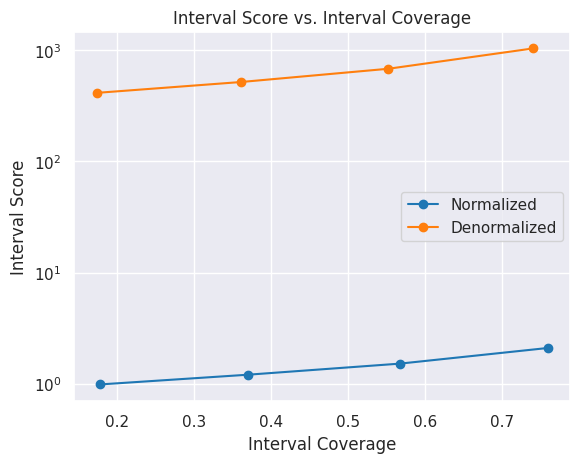

In [115]:
plt.plot(interval_coverage_scores, interval_scores, marker="o", color="tab:blue", label="Normalized")
plt.plot(interval_coverage_scores_denorm, interval_scores_denorm, marker="o", color="tab:orange", label="Denormalized")
plt.xlabel("Interval Coverage")
plt.ylabel("Interval Score")
plt.title("Interval Score vs. Interval Coverage")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

In [127]:
def mean_absolute_deviation(y_true, predictions):
    return np.mean(np.abs(y_true - predictions), axis=tuple(range(1, predictions.ndim)))

In [128]:
mads, mads_denorm = [], []
mads = mean_absolute_deviation(X_test.reshape(num_users,-1), quantiles_test)
mads_denorm = mean_absolute_deviation(X_test_denorm, quantiles_test_denorm)

In [130]:
mads

array([0.58380543, 0.47085026, 0.42061221, 0.40165496, 0.40348761,
       0.42454041, 0.47184975, 0.56910481, 0.8035629 ])

(0.0, 500.0)

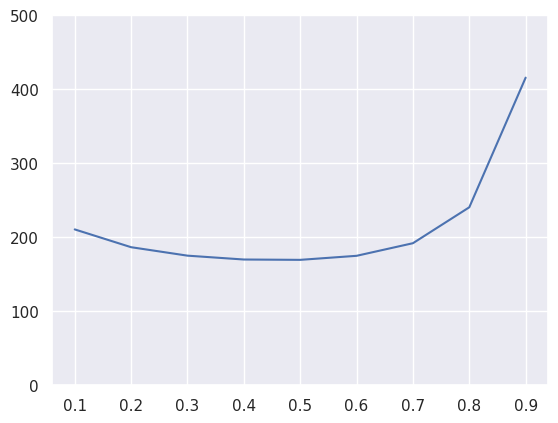

In [135]:
plt.plot(quantiles,mads_denorm)
plt.ylim(0, 500)